## 0- Imports and Constants

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

In [3]:
DATA_PATH = os.path.join(os.getcwd(), 'A_B Test Results - Test Results.csv')

In [4]:
df = pd.read_csv(DATA_PATH, skiprows=1)

df['Control'] = df['Control'].str.replace(',', '').astype(float)
df['Treatment'] = df['Treatment'].str.replace(',', '').astype(float)

In [5]:
df

,Metric Category,Metric Name,Control,Treatment
0,Participants,user_counts,5191.0,5314.0
1,Account Type Switches,Free_to_Paid,4719.0,4603.0
2,Account Type Switches,Paid_to_Free,1056.0,1088.0
3,Account Type Switches,upsell,360.0,362.0
4,Account Type Switches,downgrade,1069.0,1106.0
...,...,...,...,...
122,Template,_5Plus_Table_Clones,2.0,2.0
123,Template,_1Plus_PDF_Clones,429.0,363.0
124,Template,_5Plus_PDF_Clones,23.0,11.0
125,Template,_1Plus_Any_App_Clones,159.0,159.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Metric Category  127 non-null    object 
 1   Metric Name      127 non-null    object 
 2   Control          127 non-null    float64
 3   Treatment        127 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.1+ KB


In [7]:
df_to_use = df.copy()
df_to_use['Control'] = df_to_use['Control'].astype(float)
df_to_use['Treatment'] = df_to_use['Treatment'].astype(float)
df_to_use.set_index('Metric Name', inplace=True)
df_to_use.drop(columns=['Metric Category'], inplace=True)

In [8]:
df_to_use

,Control,Treatment
Metric Name,,
user_counts,5191.0,5314.0
Free_to_Paid,4719.0,4603.0
Paid_to_Free,1056.0,1088.0
upsell,360.0,362.0
downgrade,1069.0,1106.0
...,...,...
_5Plus_Table_Clones,2.0,2.0
_1Plus_PDF_Clones,429.0,363.0
_5Plus_PDF_Clones,23.0,11.0


## 1- Understanding the Problem

We have 2 groups in this test, which are Control and Treatment. Their spesifications are:
* Control Group: Users who signed up and subscribed **without** mandatory 3DS authentication in the first 2 hours
* Treatment Group: Users who signed up and **had to** complete 3DS verification before subscribing

We are asked to assess the test results for these 2 groups to decide if the hypothesis holds.

### Hypothesis
>Mandating 3DS authentication for early subscribers will result in a measurable decrease in both fraud-related account suspensions and refund volumes, compared to users who are not subject to 3DS.

Which makes sense for starters. Because, as also mentioned in the rationale part, "Fraudulent actors often attempt to exploit platforms **immediately after** signing up by using stolen credit cards." This extra verification layer (3DS) might be disincentive for frauds or be helpful in the discrimination of fraudulent activities.

### What makes a user fraudulent?
As stated in the explanation, their account is suspended, and the full amount paid is refunded if a user is marked as fraudulent. So, the metrics that I think would be helpful for this scenario are:
- suspended_user_counts
- refund_users
- P1_During_Test
- P7_During_Test
- P30_During_Test
- P60_During_Test
- P90_During_Test
- support_requests
- Free_to_Paid

## 2- Code-intensive Part

In [9]:
# total votes 
control_users = df_to_use.loc['user_counts', 'Control']
treatment_users = df_to_use.loc['user_counts', 'Treatment']

### 2.1- Statistical Significance Testing

In this part, I test the hypothesis using statistical significance testing method. At first, I normalize the data since the 2 groups are of different sizes. Then, I compute the percentage difference to represent the relative impact. After that comes the statistical test, which uses Z-test to determine whether the observed differences could have occured by chance. I use p < 0.05, meaning there is less than a 5% probability that the observed difference occurred by chance alone.

In [10]:
def perform_statistical_tests(df, metrics, control_users, treatment_users):
    results = []
    
    for metric in metrics:
        control_value = df.loc[metric, 'Control']
        treatment_value = df.loc[metric, 'Treatment']
        
        # rates per user
        control_rate = control_value / control_users
        treatment_rate = treatment_value / treatment_users
        
        # percentage difference
        pct_diff = ((treatment_rate - control_rate) / control_rate) * 100
        
        # z-test for proportions
        count = [control_value, treatment_value]
        nobs = [control_users, treatment_users]
        
        try:
            z_stat, p_value = proportions_ztest(count, nobs)
            significant = p_value < 0.05
        except:
            z_stat, p_value, significant = None, None, False
        
        results.append({
            'Metric': metric,
            'Control Count': control_value,
            'Treatment Count': treatment_value,
            'Control Rate': control_rate,
            'Treatment Rate': treatment_rate,
            'Percent Diff': pct_diff,
            'Z-Statistic': z_stat,
            'P-Value': p_value,
            'Significant': significant
        })
    
    return pd.DataFrame(results)

Here I define the key metrics that I will be using. To explain why I'm choosing them:

**Signups:**
- suspended_user_counts: Direct measure of accounts flagged as fraudulent

**Payments:**
- refund_users: Users requesting refunds

**Support:**
- support_requests: Users needing assistance, potentially indicating friction

**Account Type Switches:**
- Free_to_Paid: Conversion from free to paid accounts

**Payments:**
- Payment retention metrics (P1_During_Test through P90_During_Test): Users still paying after specific time periods (1, 7, 30, 60, and 90 days)

In [11]:
key_metrics = [
    'suspended_user_counts',
    'refund_users',
    'P1_During_Test',
    'P7_During_Test',
    'P30_During_Test',
    'P60_During_Test',
    'P90_During_Test',
    'support_requests',
    'Free_to_Paid'
]

In [12]:
stats_results = perform_statistical_tests(df_to_use, key_metrics, control_users, treatment_users)
stats_results

,Metric,Control Count,Treatment Count,Control Rate,Treatment Rate,Percent Diff,Z-Statistic,P-Value,Significant
0,suspended_user_counts,506.0,382.0,0.097476,0.071886,-26.253345,4.714028,2.428672e-06,True
1,refund_users,165.0,205.0,0.031786,0.038577,21.366659,-1.887953,5.903230e-02,False
2,P1_During_Test,1160.0,1394.0,0.223464,0.262326,17.390854,-4.642382,3.444154e-06,True
3,P7_During_Test,1192.0,1445.0,0.229628,0.271923,18.418913,-4.998461,5.778971e-07,True
4,P30_During_Test,1207.0,1478.0,0.232518,0.278133,19.618029,-5.358835,8.376014e-08,True
5,P60_During_Test,1228.0,1513.0,0.236563,0.284720,20.356636,-5.619406,1.916155e-08,True
6,P90_During_Test,1241.0,1527.0,0.239068,0.287354,20.197860,-5.616827,1.944955e-08,True
7,support_requests,901.0,840.0,0.173570,0.158073,-8.928189,2.135605,3.271165e-02,True
8,Free_to_Paid,4719.0,4603.0,0.909073,0.866202,-4.715891,6.949445,3.667261e-12,True


Statistics don't lie (unless they do). Based on the significance test that I've done, the hypothesis seems to hold for 8/9 metrics. If I'm to highlight some points:
- Only non-significant result is produced by refund_users. This might indicate 2 things: 
    - It really isn't significant. Which might be considered true intuitively, since refund can be done in a broad variety of cases. 
    - It is significant to a certain point, which are actually the cases other than the actual fraudulent acts. This is more sound intuitively, and explains the small difference between p-value and 0.05.
- Examining the other metrics, all but support_requests has a really low p-value. This shows an incredible statistical significance. support_requests also produces a p-value smaller than 0.05 but not as small as the others. This can be accepted as similar to the second situation with the refund_users.

Now, to visualize on these statistics:

<Figure size 1400x800 with 0 Axes>

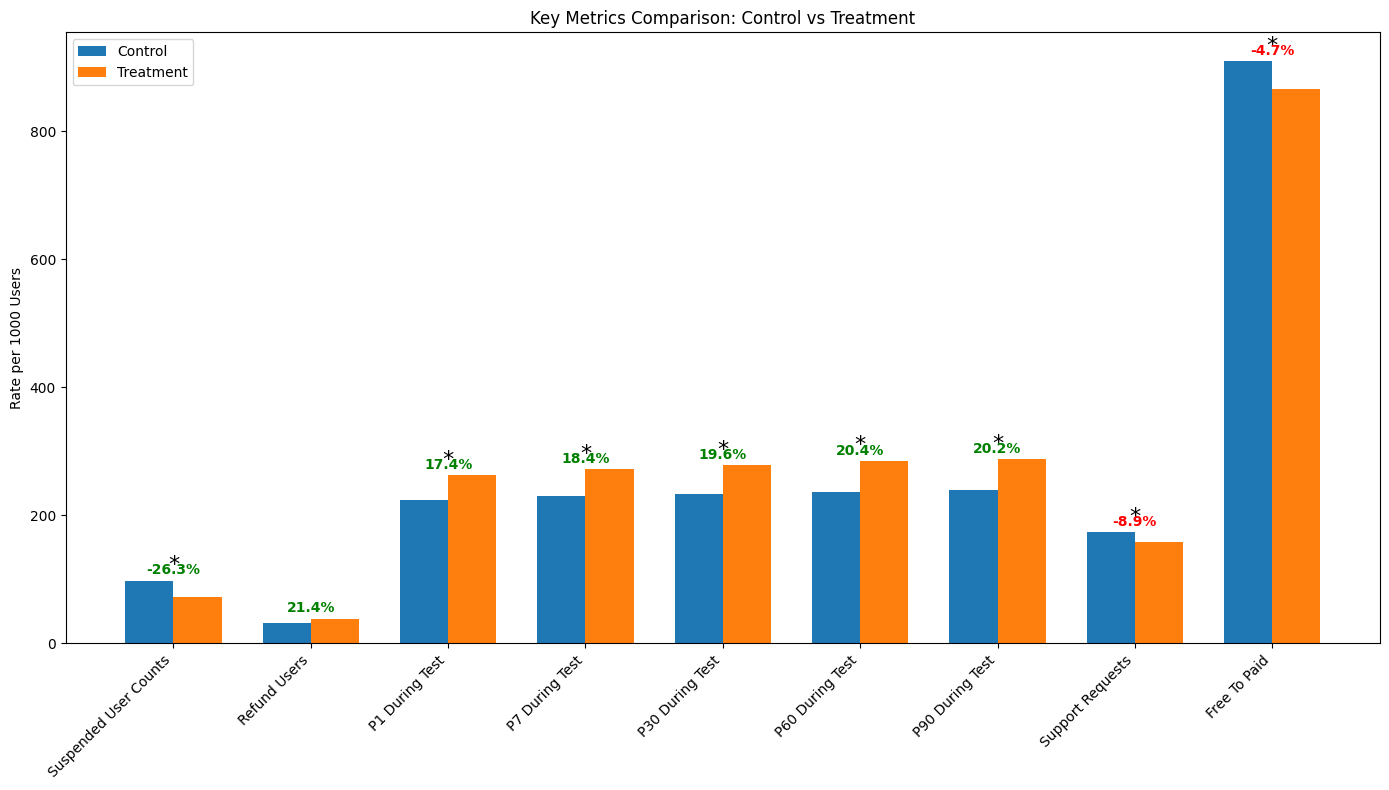

In [13]:
# rates per 1000 users for better visualization
stats_results['Control Rate (per 1000)'] = stats_results['Control Rate'] * 1000
stats_results['Treatment Rate (per 1000)'] = stats_results['Treatment Rate'] * 1000

# bar chart comparing key metrics
plt.figure(figsize=(14, 8))
metrics = stats_results['Metric'].tolist()
metrics_display = [m.replace('_', ' ').title() for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, stats_results['Control Rate (per 1000)'], width, label='Control')
bars2 = ax.bar(x + width/2, stats_results['Treatment Rate (per 1000)'], width, label='Treatment')

# annotate significant differences with asterisks
for i, is_significant in enumerate(stats_results['Significant']):
    if is_significant:
        max_height = max(stats_results['Control Rate (per 1000)'][i], stats_results['Treatment Rate (per 1000)'][i])
        ax.text(i, max_height + 15, '*', ha='center', fontsize=16)

for i, pct in enumerate(stats_results['Percent Diff']):
    y_pos = max(stats_results['Control Rate (per 1000)'][i], stats_results['Treatment Rate (per 1000)'][i]) + 10
    color = 'green' if pct > 0 else 'red'
    if metrics[i] == 'suspended_user_counts':  # special case: negative is good for suspended accounts
        color = 'green' if pct < 0 else 'red'
    ax.text(i, y_pos, f"{pct:.1f}%", ha='center', color=color, fontweight='bold')

ax.set_ylabel('Rate per 1000 Users')
ax.set_title('Key Metrics Comparison: Control vs Treatment')
ax.set_xticks(x)
ax.set_xticklabels(metrics_display, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

Here we can see and compare the change better. 26 percent of drop in Suspended User Counts is highly motivating. This is actually the main metric that should be considered, and here we see a big drop and an asterisk (*), stating that this statistic is significant.

#### So far so good, so what?
Correlation does not mean causation, but is a good thing to have. Now I will try to support the outcomes of the statistical significance test using some other methods.

### 2.2 - Payment Retention Analysis Over Time

This analysis uses only payment retention metrics. My aim here is to analyze if retention over time increases, and if so, how much it increases based on the group. It is a time series analysis on the simpler side, without complex datetime variables. 

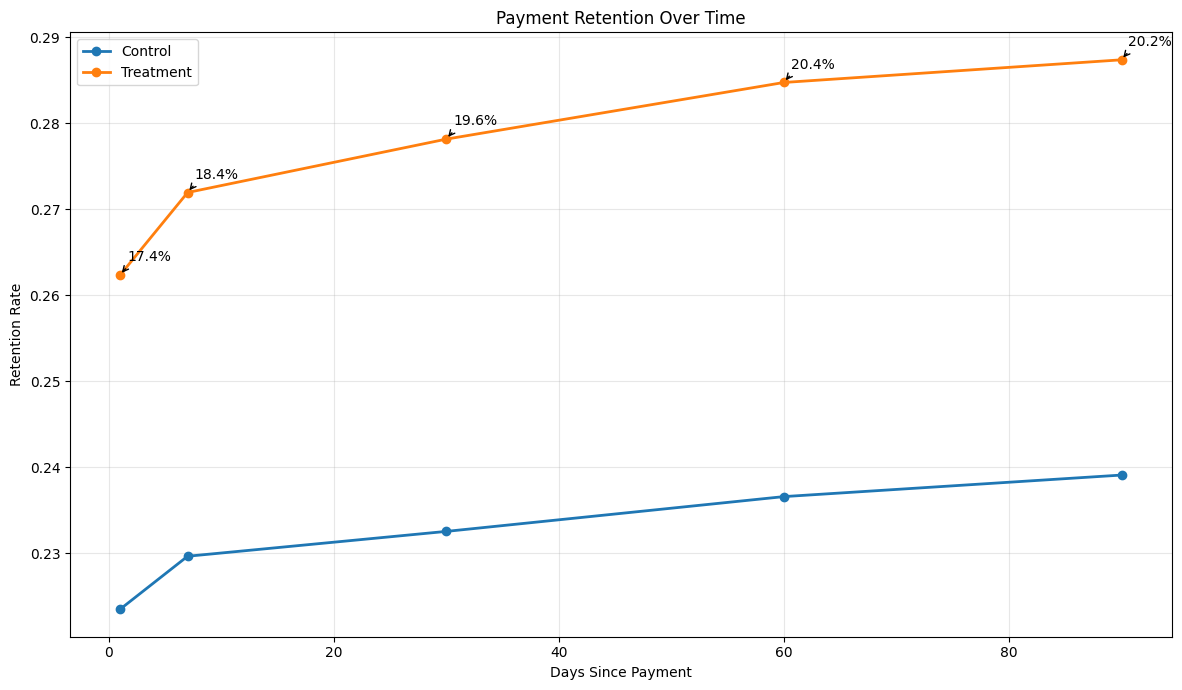

,Days,Control Rate,Treatment Rate,Percent Improvement
0,1,0.223464,0.262326,17.390854
1,7,0.229628,0.271923,18.418913
2,30,0.232518,0.278133,19.618029
3,60,0.236563,0.284720,20.356636
4,90,0.239068,0.287354,20.197860


In [14]:
retention_metrics = ['P1_During_Test', 'P7_During_Test', 'P30_During_Test', 'P60_During_Test', 'P90_During_Test']
retention_days = [1, 7, 30, 60, 90]

retention_data = pd.DataFrame({
    'Days': retention_days,
    'Control Rate': [df_to_use.loc[m, 'Control']/control_users for m in retention_metrics],
    'Treatment Rate': [df_to_use.loc[m, 'Treatment']/treatment_users for m in retention_metrics]
})

retention_data['Percent Improvement'] = ((retention_data['Treatment Rate'] - retention_data['Control Rate']) / 
                                        retention_data['Control Rate']) * 100

plt.figure(figsize=(12, 7))
plt.plot(retention_data['Days'], retention_data['Control Rate'], 'o-', label='Control', linewidth=2)
plt.plot(retention_data['Days'], retention_data['Treatment Rate'], 'o-', label='Treatment', linewidth=2)

for i, row in retention_data.iterrows():
    plt.annotate(f"{row['Percent Improvement']:.1f}%", 
                xy=(row['Days'], row['Treatment Rate']),
                xytext=(5, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.xlabel('Days Since Payment')
plt.ylabel('Retention Rate')
plt.title('Payment Retention Over Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

retention_data

**What can we observe from this plot?**
- Lines are flat or gradually increasing for both groups. This can be accepted as the success of the service/provider.
- Treatment group has a higher performance for all metrics. Here the percentage values over the orange line indicates the percentage difference between the groups.
- The gap between groups almost always increases. There is an incredibly small drop at the last part of the plot but it seems to be nothing to worry about. This fact actually can be accepted in the favor of 3DS being a "quality filter" effect, retaining more valuable customers.


### 2.3 - Quantitative Trade-off Assessment

In [ ]:
suspended_control = df_to_use.loc['suspended_user_counts', 'Control']
suspended_treatment = df_to_use.loc['suspended_user_counts', 'Treatment']
refund_control = df_to_use.loc['refund_users', 'Control']
refund_treatment = df_to_use.loc['refund_users', 'Treatment']

suspended_diff = suspended_treatment - suspended_control
refund_diff = refund_treatment - refund_control

# per 1000 user rates
suspended_control_rate = (suspended_control / control_users) * 1000
suspended_treatment_rate = (suspended_treatment / treatment_users) * 1000
refund_control_rate = (refund_control / control_users) * 1000
refund_treatment_rate = (refund_treatment / treatment_users) * 1000

tradeoff_data = pd.DataFrame({
    'Metric': ['Suspended Accounts', 'Refund Requests'],
    'Control Count': [suspended_control, refund_control],
    'Treatment Count': [suspended_treatment, refund_treatment],
    'Control Rate (per 1000)': [suspended_control_rate, refund_control_rate],
    'Treatment Rate (per 1000)': [suspended_treatment_rate, refund_treatment_rate],
    'Net Change': [suspended_diff, refund_diff],
    'Percent Change': [
        ((suspended_treatment_rate - suspended_control_rate) / suspended_control_rate) * 100,
        ((refund_treatment_rate - refund_control_rate) / refund_control_rate) * 100
    ]
})

# fraud-refund ratio (how many fewer frauds per additional refund)
if refund_diff > 0:
    fraud_refund_ratio = abs(suspended_diff) / refund_diff
    interpretation = f"For every additional refund, approximately {fraud_refund_ratio:.2f} fraudulent accounts were prevented"
else:
    fraud_refund_ratio = float('inf')
    interpretation = "3DS reduced fraud without increasing refunds"

print("Fraud-Refund Trade-off Analysis:")
display(tradeoff_data)
print(interpretation)

Fraud-Refund Trade-off Analysis:


,Metric,Control Count,Treatment Count,Control Rate (per 1000),Treatment Rate (per 1000),Net Change,Percent Change
0,Suspended Accounts,506.0,382.0,97.476401,71.885585,-124.0,-26.253345
1,Refund Requests,165.0,205.0,31.785783,38.577343,40.0,21.366659


For every additional refund, approximately 3.10 fraudulent accounts were prevented


This is actually happy news. Let's interpret the results:
- We see a negative value in suspended accounts' "Net Change", which indicates fewer fraudulent activities. The percent change shows the relative magnitude of fraud reduction.
- We see a positive number in refund requests' "Net Change", this actually indicates a **trade-off** for this method. This means, the method can be **improved.**

For the decision of this trade-off, I choose to use a ROI (return on investment) ratio, which is the fraud-refund ratio in this case. I get a ratio of 3.10. This is a high ratio, which indicates that the security benefit likely outweighs the friction cost.

---

scorecard

In [18]:
# Create a scorecard to summarize results
def create_scorecard(stats_results):
    # Organize metrics into categories
    fraud_metrics = ['suspended_user_counts']
    customer_experience = ['refund_users', 'support_requests']
    business_impact = ['Free_to_Paid', 'P90_During_Test']
    
    scorecard = {}
    
    # Function to evaluate a metric
    def evaluate_metric(metric_name, positive_direction='down'):
        metric_data = stats_results[stats_results['Metric'] == metric_name].iloc[0]
        pct_change = metric_data['Percent Diff']
        significant = metric_data['Significant']
        
        if positive_direction == 'down':
            is_positive = pct_change < 0
        else:
            is_positive = pct_change > 0
            
        rating = "✓" if is_positive else "✗"
        sig_mark = "*" if significant else ""
        
        return {
            'Change': f"{pct_change:.1f}%{sig_mark}",
            'Rating': rating,
            'Positive': is_positive,
            'Significant': significant
        }
    
    # Evaluate fraud metrics
    scorecard['Fraud Prevention'] = {
        'suspended_user_counts': evaluate_metric('suspended_user_counts', 'down')
    }
    
    # Evaluate customer experience metrics
    scorecard['Customer Experience'] = {
        'refund_users': evaluate_metric('refund_users', 'down'),
        'support_requests': evaluate_metric('support_requests', 'down')
    }
    
    # Evaluate business impact metrics
    scorecard['Business Impact'] = {
        'Free_to_Paid': evaluate_metric('Free_to_Paid', 'up'),
        'P90_During_Test': evaluate_metric('P90_During_Test', 'up')
    }
    
    return scorecard

# Generate the scorecard
scorecard = create_scorecard(stats_results)

# Display the scorecard in a formatted way
print("### 3DS Authentication Impact Scorecard ###\n")
for category, metrics in scorecard.items():
    print(f"\n## {category}")
    for metric, result in metrics.items():
        rating_color = "green" if result['Positive'] else "red"
        sig_marker = " (statistically significant)" if result['Significant'] else ""
        print(f"- {metric}: {result['Change']} {result['Rating']} {sig_marker}")

### 3DS Authentication Impact Scorecard ###


## Fraud Prevention
- suspended_user_counts: -26.3%* ✓  (statistically significant)

## Customer Experience
- refund_users: 21.4% ✗ 
- support_requests: -8.9%* ✓  (statistically significant)

## Business Impact
- Free_to_Paid: -4.7%* ✗  (statistically significant)
- P90_During_Test: 20.2%* ✓  (statistically significant)


final

In [19]:
# Get key metrics for final recommendation
suspended_pct = stats_results[stats_results['Metric'] == 'suspended_user_counts']['Percent Diff'].values[0]
refund_pct = stats_results[stats_results['Metric'] == 'refund_users']['Percent Diff'].values[0]
p90_pct = stats_results[stats_results['Metric'] == 'P90_During_Test']['Percent Diff'].values[0]

# Generate final recommendation
print("## Final Recommendation")
print("\nBased on the analysis of key metrics:")

# Analyze fraud prevention impact
if suspended_pct < 0:
    print(f"✓ 3DS authentication reduced fraudulent account suspensions by {abs(suspended_pct):.1f}%")
else:
    print(f"✗ 3DS authentication did not reduce fraudulent account suspensions ({suspended_pct:.1f}%)")

# Analyze refund impact
if refund_pct < 0:
    print(f"✓ Refund requests decreased by {abs(refund_pct):.1f}%")
else:
    print(f"✗ Refund requests increased by {refund_pct:.1f}%")

# Analyze retention impact
if p90_pct > 0:
    print(f"✓ 90-day payment retention improved by {p90_pct:.1f}%")
else:
    print(f"✗ 90-day payment retention decreased by {abs(p90_pct):.1f}%")

# Make final recommendation
if suspended_pct < 0 and p90_pct > 0:
    print("\nRECOMMENDATION: Implement 3DS authentication")
    print("The security benefits and improved long-term retention outweigh the potential increase in refunds.")
    if refund_pct > 0:
        print(f"Consider investigating why refunds increased by {refund_pct:.1f}% and addressing any legitimate user friction.")
else:
    print("\nRECOMMENDATION: Further testing needed before full implementation")
    print("The current results don't show a clear benefit that outweighs potential drawbacks.")

## Final Recommendation

Based on the analysis of key metrics:
✓ 3DS authentication reduced fraudulent account suspensions by 26.3%
✗ Refund requests increased by 21.4%
✓ 90-day payment retention improved by 20.2%

RECOMMENDATION: Implement 3DS authentication
The security benefits and improved long-term retention outweigh the potential increase in refunds.
Consider investigating why refunds increased by 21.4% and addressing any legitimate user friction.


additional

In [20]:
# Calculate conversion rates for broader business impact
free_to_paid_control = df_to_use.loc['Free_to_Paid', 'Control'] / control_users
free_to_paid_treatment = df_to_use.loc['Free_to_Paid', 'Treatment'] / treatment_users

# Test whether the difference in conversion rates is statistically significant
count_successes = [
    df_to_use.loc['Free_to_Paid', 'Control'], 
    df_to_use.loc['Free_to_Paid', 'Treatment']
]
count_total = [control_users, treatment_users]
z_stat, p_val = proportions_ztest(count_successes, count_total)

print("Free to Paid Conversion Rate:")
print(f"Control: {free_to_paid_control:.4f} ({free_to_paid_control*100:.2f}%)")
print(f"Treatment: {free_to_paid_treatment:.4f} ({free_to_paid_treatment*100:.2f}%)")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print(f"Statistically significant: {p_val < 0.05}")

Free to Paid Conversion Rate:
Control: 0.9091 (90.91%)
Treatment: 0.8662 (86.62%)
Z-statistic: 6.9494
P-value: 0.0000
Statistically significant: True
